In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from datapreprocessfunction_code import function_process, readfile, rename_cols,annon,outers_join
%matplotlib inline

A supervised learning technique called backpropagation for training.
Its multiple layers and non-linear activation distinguish MLP from a linear perceptron.

In [2]:
fig_size    = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [47]:
def remove_dup(strng):
    '''
     Input a string and split them 
    '''
    return ', '.join(list(dict.fromkeys(strng.split(', '))))


In [18]:
%store -r mutations_BRCA_agg_clin
mutations_BRCA_agg_clin = rename_cols(mutations_BRCA_agg_clin,"ER.Status","ER_status")
mutations_BRCA_agg_clin = rename_cols(mutations_BRCA_agg_clin,"PR.Status","PR_status")
mutations_BRCA_agg_clin["regulation"]   = np.where(mutations_BRCA_agg_clin['logFC']>=0.58,'up','down')

mapping = {'Positive': 1, 'Negative': 1}
mutations_BRCA_agg_clin['ER_status'] = mutations_BRCA_agg_clin['ER_status'].fillna(0)
mutations_BRCA_agg_clin = mutations_BRCA_agg_clin.replace({'ER_status': mapping})
mutations_BRCA_agg_clin.drop(['gene_sym','sample'],inplace=True,axis=1)

<AxesSubplot:ylabel='ER_status'>

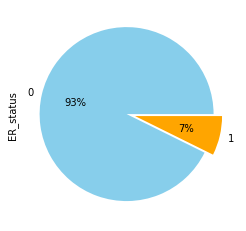

In [19]:
mutations_BRCA_agg_clin.ER_status.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'],
                                                      explode=(0.05, 0.05))

<AxesSubplot:xlabel='type', ylabel='count'>

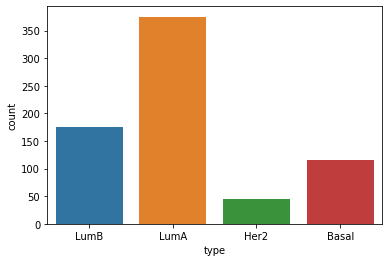

In [20]:
sns.countplot(x='type', data=mutations_BRCA_agg_clin)


<AxesSubplot:xlabel='Variant_Type', ylabel='count'>

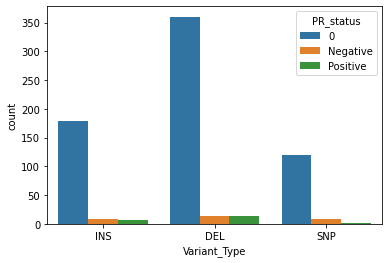

In [21]:
sns.countplot(x='Variant_Type', hue='PR_status', data=mutations_BRCA_agg_clin)

In [22]:
categorical_columns = ['Variant_Type','type','regulation']
numerical_columns   = ['vaf','logFC']
output =['ER_status']
for category in categorical_columns:
    mutations_BRCA_agg_clin[category] = mutations_BRCA_agg_clin[category].astype('category')
#convert the categorical columns to tensors.
# data in the four categorical columns into numpy arrays and then stack all the columns horizontally
vt = mutations_BRCA_agg_clin['Variant_Type'].cat.codes.values
ty = mutations_BRCA_agg_clin['type'].cat.codes.values
rg = mutations_BRCA_agg_clin['regulation'].cat.codes.values
categorical_data = np.stack([vt, ty, rg], 1)
categorical_data[:10]

array([[1, 3, 0],
       [0, 2, 0],
       [0, 1, 0],
       [2, 3, 1],
       [0, 3, 1],
       [0, 2, 1],
       [1, 3, 1],
       [0, 3, 0],
       [0, 2, 0],
       [0, 2, 0]], dtype=int8)

In [23]:
mutations_BRCA_agg_clin['Variant_Type'].head()


0    INS
1    DEL
2    DEL
3    SNP
4    DEL
Name: Variant_Type, dtype: category
Categories (3, object): ['DEL', 'INS', 'SNP']

In [24]:
mutations_BRCA_agg_clin.shape

(711, 8)

In [25]:
#create a tensor from the aforementioned numpy array, 
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[1, 3, 0],
        [0, 2, 0],
        [0, 1, 0],
        [2, 3, 1],
        [0, 3, 1],
        [0, 2, 1],
        [1, 3, 1],
        [0, 3, 0],
        [0, 2, 0],
        [0, 2, 0]])

Numpy neumerical data

In [26]:
numerical_data = np.stack([mutations_BRCA_agg_clin[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[ 0.5000, -1.2934],
        [ 0.5556, -1.2934],
        [ 0.3333, -1.2934],
        [ 0.5000,  0.8647],
        [ 0.5000,  1.1244]])

Convert output into numpy tensors

In [27]:
outputs = torch.tensor(mutations_BRCA_agg_clin[output].values).flatten()
outputs[:5]

tensor([0, 0, 0, 0, 0])

In [28]:
print(categorical_data.shape)
print(numerical_data.shape)


torch.Size([711, 3])
torch.Size([711, 2])


In [29]:
categorical_column_sizes = [len(mutations_BRCA_agg_clin[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(3, 2), (4, 2), (2, 1)]


In [30]:
total_records = 711
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs       = outputs[:total_records-test_records]
test_outputs        = outputs[total_records-test_records:total_records]

In [31]:
print(len(categorical_train_data))
print(len(numerical_train_data))
print(len(train_outputs))

print(len(categorical_test_data))
print(len(numerical_test_data))
print(len(test_outputs))

569
569
569
142
142
142


Model generation class

In [32]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols
        
        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
       #multilayer percpreton is used
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        #embedding of the categorical columns takes place
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        #batch normalization of the numerical columns
        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [33]:
print(categorical_embedding_sizes)


[(3, 2), (4, 2), (2, 1)]


In [34]:
numerical_train_data

tensor([[ 0.5000, -1.2934],
        [ 0.5556, -1.2934],
        [ 0.3333, -1.2934],
        ...,
        [ 0.4444, -0.9094],
        [ 0.3333, -0.9087],
        [ 0.4118, -2.1365]])

In [35]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4)
#print(model)
model(categorical_train_data, numerical_train_data)

tensor([[-0.6966,  0.2145],
        [-0.4567, -0.6010],
        [ 0.0943,  0.1042],
        ...,
        [ 0.7319, -0.7335],
        [ 0.4293, -0.2345],
        [-0.6572, -1.0919]], grad_fn=<AddmmBackward>)

In [36]:
categorical_embedding_sizes

[(3, 2), (4, 2), (2, 1)]

In [37]:
loss_function = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
numerical_data[:5]


tensor([[ 0.5000, -1.2934],
        [ 0.5556, -1.2934],
        [ 0.3333, -1.2934],
        [ 0.5000,  0.8647],
        [ 0.5000,  1.1244]])

In [39]:
epochs = 300
aggregated_losses = []

In [40]:
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    

epoch:   1 loss: 0.81543154
epoch:  26 loss: 0.71506315
epoch:  51 loss: 0.63303787
epoch:  76 loss: 0.57970643
epoch: 101 loss: 0.50922191
epoch: 126 loss: 0.44302714
epoch: 151 loss: 0.39171812
epoch: 176 loss: 0.34273386
epoch: 201 loss: 0.31566525
epoch: 226 loss: 0.31520391
epoch: 251 loss: 0.29790169
epoch: 276 loss: 0.29593834
epoch: 300 loss: 0.2829117775


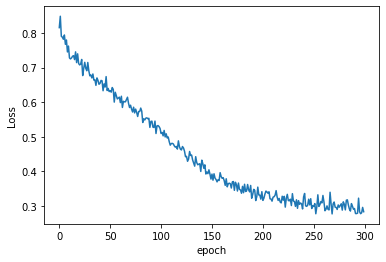

In [41]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

 look at the loss on validation set for figuring out the overfitting using the validation set y_val

In [42]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')
y_val = np.argmax(y_val, axis=1)

Loss: 0.24516590


In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[133   3]
 [  6   0]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       136
           1       0.00      0.00      0.00         6

    accuracy                           0.94       142
   macro avg       0.48      0.49      0.48       142
weighted avg       0.92      0.94      0.93       142

0.9366197183098591
